# Exploratory Analysis

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
sns.set()

## Merged Data

In [8]:
data_path = 'D:\DATA\OurFoods'
df = pd.read_csv(os.path.join(data_path, 'merged_amz-off_1.csv.gz'),\
                 dtype={'customer_id': 'object', 'product_parent': 'object', \
                        'star_rating': pd.Int64Dtype(), 'helpful_votes': pd.Int64Dtype(), 
                        'total_votes': pd.Int64Dtype(), \
                        'code': 'object'},
                 compression='gzip')
# convert reivew_date to datetime object
df.review_date = pd.to_datetime(df.review_date)
# drop the rows without nutrient data
df = df[df.energy_100g.notna()]
df.shape

(147304, 134)

In [27]:
df.iloc[0:10, 125:]

,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g,tokens_x.1,tokens_y,filter,tokens_y.1
0,NaN,NaN,NaN,NaN,NaN,"('kadoya', 'oil', 'pure', 'sesame')","('kadoya', 'oil', 'pure', 'sesame')",1,"('kadoya', 'oil', 'pure', 'sesame')"
1,NaN,NaN,NaN,NaN,NaN,"('kadoya', 'oil', 'pure', 'sesame')","('kadoya', 'oil', 'pure', 'sesame')",1,"('kadoya', 'oil', 'pure', 'sesame')"
2,NaN,NaN,NaN,NaN,NaN,"('kadoya', 'oil', 'pure', 'sesame')","('kadoya', 'oil', 'pure', 'sesame')",1,"('kadoya', 'oil', 'pure', 'sesame')"
3,NaN,NaN,NaN,NaN,NaN,"('kadoya', 'oil', 'pure', 'sesame')","('kadoya', 'oil', 'pure', 'sesame')",1,"('kadoya', 'oil', 'pure', 'sesame')"
4,NaN,NaN,NaN,NaN,NaN,"('kadoya', 'oil', 'pure', 'sesame')","('kadoya', 'oil', 'pure', 'sesame')",1,"('kadoya', 'oil', 'pure', 'sesame')"
5,NaN,NaN,NaN,NaN,NaN,"('kadoya', 'oil', 'pure', 'sesame')","('kadoya', 'oil', 'pure', 'sesame')",1,"('kadoya', 'oil', 'pure', 'sesame')"
6,NaN,NaN,NaN,NaN,NaN,"('kadoya', 'oil', 'pure', 'sesame')","('kadoya', 'oil', 'pure', 'sesame')",1,"('kadoya', 'oil', 'pure', 'sesame')"
7,NaN,NaN,NaN,NaN,NaN,"('kadoya', 'oil', 'pure', 'sesame')","('kadoya', 'oil', 'pure', 'sesame')",1,"('kadoya', 'oil', 'pure', 'sesame')"
8,NaN,NaN,NaN,NaN,NaN,"('kadoya', 'oil', 'pure', 'sesame')","('kadoya', 'oil', 'pure', 'sesame')",1,"('kadoya', 'oil', 'pure', 'sesame')"
9,NaN,NaN,NaN,NaN,NaN,"('kadoya', 'oil', 'pure', 'sesame')","('kadoya', 'oil', 'pure', 'sesame')",1,"('kadoya', 'oil', 'pure', 'sesame')"


### Subset on main nutrients
+ Amazon Reivew attributes & Product Main Nutrients
+ including: ['energy_100g', 'fat_100g', 'fiber_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'sugars_100g']

In [9]:
main = ['energy_100g', 'fat_100g', 'fiber_100g', 'carbohydrates_100g', \
        'proteins_100g', 'salt_100g', 'sodium_100g', 'sugars_100g']
sub = df.loc[:, df.columns[:13].tolist()+main]
# extract only data with nutrients and remove outliners
sub = sub[((sub.energy_100g.notna()) & (sub.energy_100g < 1000))]
sub.shape

(62025, 21)

In [10]:
sub[sub.energy_100g > 10].shape, sub[sub.energy_100g <= 10].shape
# note the majority is low energy product

((47257, 21), (14768, 21))

In [11]:
sub[['review_date', 'star_rating']].groupby(sub.review_date.dt.year).count()
# not many data before 2005

,review_date,star_rating
review_date,,
2003.0,10,10
2004.0,34,34
2005.0,99,99
2006.0,197,197
2007.0,575,575
2008.0,814,814
2009.0,1162,1162
2010.0,1530,1530
2011.0,2481,2481


In [12]:
# get data after 2005
sub = sub[sub.review_date.dt.year >= 2005]
sub.shape

(61980, 21)

### Group by time
+ by year
+ by month

In [13]:
# yearly differece in buying behaviors
sub[['review_date', 'star_rating']+main].groupby(sub.review_date.dt.year).mean()

,review_date,star_rating,energy_100g,fat_100g,fiber_100g,carbohydrates_100g,proteins_100g,salt_100g,sodium_100g,sugars_100g
review_date,,,,,,,,,,
2005,2005-07-19 02:40:00.000000000,4.343434,314.864543,5.322211,2.019216,11.622472,2.528987,21.822207,8.729287,7.193489
2006,2006-07-31 23:30:45.685279232,4.345178,386.256150,6.025493,2.116292,15.074297,3.076181,282.239651,112.779696,8.276505
2007,2007-07-08 02:17:44.347826176,4.288696,307.119600,4.305331,4.092199,13.556465,2.545768,7.659222,3.049175,7.721700
2008,2008-07-11 18:04:25.356265216,4.288698,282.273040,4.205611,4.550190,11.420663,2.495671,11.246059,4.491522,6.315436
2009,2009-07-13 01:18:04.337349632,4.320998,261.770568,2.796604,4.427221,10.998004,1.883205,8.285375,3.284991,7.361118
2010,2010-07-10 05:33:10.588235264,4.203268,280.795688,2.415771,3.419220,11.207440,1.959669,7.009677,2.795491,7.764645
2011,2011-07-13 02:37:52.309552640,4.150746,303.285460,3.854042,4.963424,12.004576,2.363129,13.585972,5.427171,7.456319
2012,2012-07-28 10:43:11.729323264,4.156250,321.711054,3.346183,4.620672,11.960329,2.797785,8.685577,3.464382,7.181147
2013,2013-07-08 00:58:06.315789568,4.364386,316.333324,3.507887,5.607626,12.612449,2.547845,14.781572,5.901221,7.251053


In [14]:
# monthly difference in buying behaviors
sub[['review_date']+main].groupby(sub.review_date.dt.month).mean()

,energy_100g,fat_100g,fiber_100g,carbohydrates_100g,proteins_100g,salt_100g,sodium_100g,sugars_100g
review_date,,,,,,,,
1,302.718979,3.395503,4.354465,12.114399,2.488869,16.533181,6.603085,7.306726
2,305.770974,3.739309,4.660929,11.691596,2.602050,15.915616,6.359072,6.831532
3,308.579366,3.823304,4.657445,12.229777,2.559601,15.522402,6.195790,7.224178
4,307.536077,4.007973,5.021809,12.030484,2.493159,18.463494,7.372606,6.884419
5,305.881848,3.770103,4.209807,11.765826,2.512100,11.754797,4.689680,7.028433
6,307.934708,3.626653,4.587817,12.389496,2.498112,18.456058,7.364534,7.202815
7,301.533108,3.934715,4.640390,12.067333,2.488253,15.166496,6.055806,7.016572
8,280.677828,3.522954,4.302306,11.182962,2.487332,14.803754,5.904351,6.682790
9,304.140259,3.459050,5.280196,12.188124,2.613459,15.130202,6.033826,6.985154


### Group by nutrients
+ by energy
+ by sugars

In [15]:
sub.energy_100g.describe()

count    61980.000000
mean       303.707451
std        303.877356
min          0.000000
25%         21.000000
50%        201.000000
75%        544.000000
max        996.000000
Name: energy_100g, dtype: float64

In [16]:
# rating on each level of energy
sub[['review_date', 'star_rating']+main]\
    .groupby(pd.cut(sub.energy_100g, [0.0, 50, 100, 200, 300, 500, 1000]))[['star_rating']].mean()

,star_rating
energy_100g,
"(0.0, 50.0]",4.347257
"(50.0, 100.0]",4.159621
"(100.0, 200.0]",4.265077
"(200.0, 300.0]",4.273486
"(300.0, 500.0]",4.447869
"(500.0, 1000.0]",4.337629


In [17]:
sub.sugars_100g.describe()

count    56784.000000
mean         7.091969
std         11.797259
min          0.000000
25%          0.000000
50%          2.700000
75%         10.000000
max        100.000000
Name: sugars_100g, dtype: float64

In [18]:
# rating on each level of sugars
sub[['review_date', 'star_rating']+main]\
    .groupby(pd.cut(sub.sugars_100g, [0.0, 2.0, 5.0, 10.0, 50.0, 100]))[['star_rating']].mean()

,star_rating
sugars_100g,
"(0.0, 2.0]",4.335425
"(2.0, 5.0]",4.212301
"(5.0, 10.0]",4.366455
"(10.0, 50.0]",4.313758
"(50.0, 100.0]",4.502447


### Plots 
+ monthly buying behaviors about energy/sugars
+ ratings on product of different energy/sugars 

In [19]:
from calendar import month_name

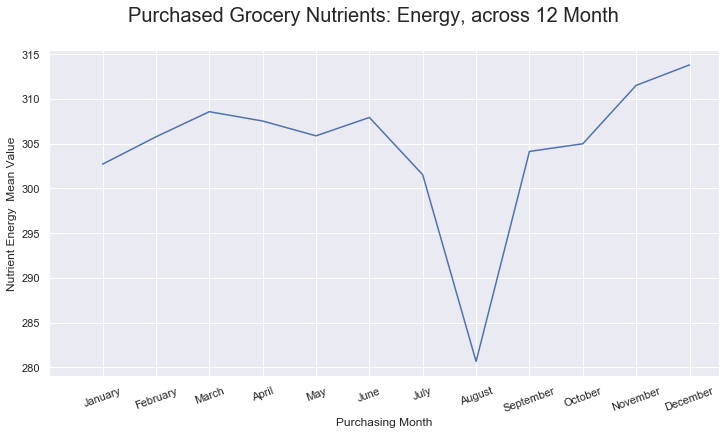

In [20]:
plt.figure(figsize=(12, 6))
tmp = sub[['review_date']+main].groupby(sub.review_date.dt.month)\
        .mean().reset_index().drop('fiber_100g', axis=1)
sns.lineplot(x='review_date', y='energy_100g', data=tmp)
plt.xlabel('Purchasing Month')
plt.xticks(np.arange(13), month_name[0:13], rotation=20)
plt.ylabel('Nutrient Energy  Mean Value')
plt.suptitle('Purchased Grocery Nutrients: Energy, across 12 Month', fontsize=20)

plt.savefig('nutrients-energy.png', bbox_inches='tight', dpi=300)
plt.show()
# why dropping at near August? need to investigate

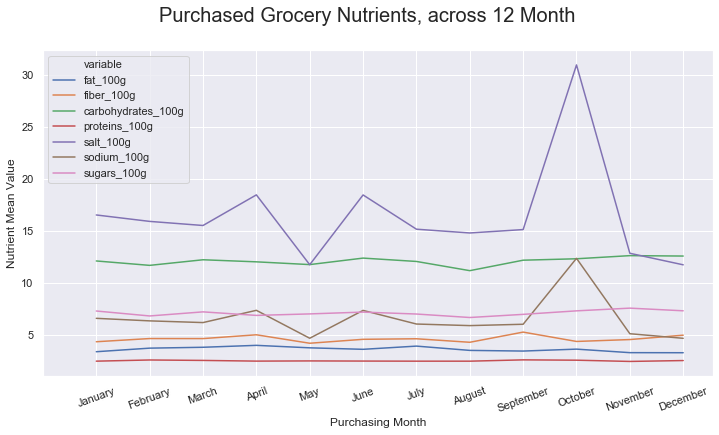

In [21]:
plt.figure(figsize=(12, 6))
tmp = sub[['review_date']+main].groupby(sub.review_date.dt.month)\
        .mean().reset_index().drop('energy_100g', axis=1)
sns.lineplot(x='review_date', y='value', hue='variable', \
             data=tmp.melt(id_vars='review_date', value_vars=tmp.columns[1:]))
plt.xlabel('Purchasing Month')
plt.xticks(np.arange(13), month_name[0:13], rotation=20)
plt.ylabel('Nutrient Mean Value')
plt.suptitle('Purchased Grocery Nutrients, across 12 Month', fontsize=20)
plt.savefig('nutrients-all.png', bbox_inches='tight', dpi=300)
plt.show()



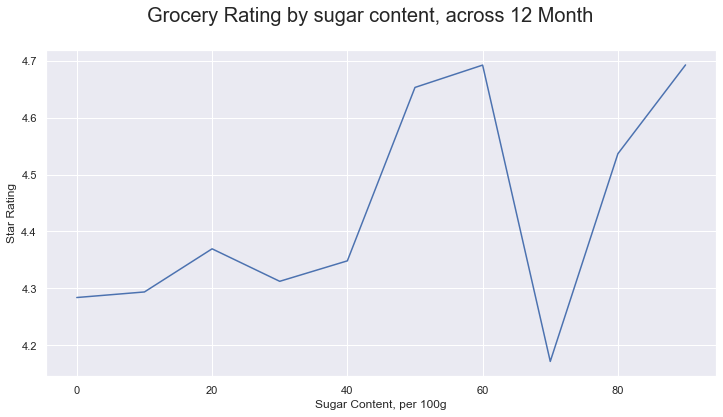

In [22]:
plt.figure(figsize=(12, 6))
tmp = sub[['review_date', 'star_rating']+main]\
        .groupby(pd.cut(sub.sugars_100g,np.arange(0, 101, 10)))[['star_rating']].mean()
sns.lineplot(x=np.arange(0, 100, 10), y='star_rating', data=tmp)
plt.xlabel('Sugar Content, per 100g')
plt.ylabel('Star Rating')
plt.suptitle('Grocery Rating by sugar content, across 12 Month', fontsize=20)
plt.savefig('sugar.png', bbox_inches='tight', dpi=300)
plt.show()



In [23]:
df.columns.values

array(['customer_id', 'review_id', 'product_parent', 'product_title',
       'star_rating', 'helpful_votes', 'total_votes', 'vine',
       'verified_purchase', 'review_headline', 'review_body',
       'review_date', 'tokens_x', 'product_name', 'allergens_en',
       'serving_quantity', 'no_nutriments', 'additives_n',
       'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil',
       'ingredients_that_may_be_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil', 'nova_group',
       'energy_100g', 'energy-from-fat_100g', 'fat_100g',
       'saturated-fat_100g', '-butyric-acid_100g', '-caproic-acid_100g',
       '-caprylic-acid_100g', '-capric-acid_100g', '-lauric-acid_100g',
       '-myristic-acid_100g', '-palmitic-acid_100g', '-stearic-acid_100g',
       '-arachidic-acid_100g', '-behenic-acid_100g',
       '-lignoceric-acid_100g', '-cerotic-acid_100g',
       '-montanic-acid_100g', '-melissic-acid_100g',
       'monounsaturated-fat_100g', 'polyunsaturated-fat_100g',
 

In [24]:
# for having grades
df2 = df[df.nutrition_grade_fr.notna()]
df2.reset_index(inplace=True, drop=True)
df2.shape

AttributeError: 'DataFrame' object has no attribute 'nutrition_grade_fr'

In [ ]:
# get the index with a string in the cell of a column
def get_category(string, column, dataframe): 
    idx_list = []
    for idx, row in dataframe.iterrows():
        if row[column] is not np.nan and string in row[column]:
            idx_list.append(idx)
    return idx_list

## Are Sugary Snacks always unhealthy? What is the healthiest in this category?
Sub-categories:   
Bars, Biscuits and cakes, Chocolates, Confectioneries, Popcorn, Viennoiseries

In [ ]:
sugary_snacks = get_category('en:sugary-snacks', 'categories_tags', df2)

In [ ]:
df_ss = df2.iloc[sugary_snacks, :]

In [ ]:
df_ss = df_ss[['code', 'categories_tags', 'energy_100g', 'fat_100g', 'fiber_100g', \
       'proteins_100g', 'salt_100g', 'sodium_100g', 'sugars_100g', 'cocoa_100g', \
       'nutrition_grade_fr', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']]
df_ss.reset_index(inplace=True, drop=True)
df_ss.shape

In [ ]:
ss_sub = set(['en:bars', 'en:biscuits-and-cakes', 'en:chocolates', \
          'en:confectioneries', 'en:popcorn', 'en:viennoiseries'])

In [ ]:
def create_sub(row):
    cats = list(ss_sub.intersection(set(row.split(','))))
    if len(cats) != 0: return cats[0]
    else: return np.nan

In [ ]:
df_ss['sub_category'] = df_ss.categories_tags.apply(create_sub)
df_ss.sub_category = df_ss.sub_category.astype('category')
df_ss = df_ss.drop('categories_tags', axis=1)

In [ ]:
# drop rows that have NaN for: sub_category, energy_100g, fat_100g
df_ss = df_ss[df_ss.sub_category.notnull() & df_ss.energy_100g.notnull() & df_ss.fat_100g.notnull()]
# fill NaN in fiber_100g with 0, i.e. this sweet has no fiber content
df_ss.fiber_100g = df_ss.fiber_100g.fillna(0)

In [ ]:
tmp = df_ss[['code', 'sub_category', 'nutrition_grade_fr']].groupby(by=['sub_category', 'nutrition_grade_fr']).count()
tmp['percentage'] = None

In [ ]:
for idx in tmp.index.levels[0].values: 
    tmp.loc[idx, 'percentage'] = (tmp.loc[idx, 'code'] / sum(tmp.loc[idx, 'code'])).values * 100

In [ ]:
total = tmp.loc[pd.IndexSlice[:, :], 'code'].values.sum()
sugary_all = []
for idx2 in tmp.index.levels[1].values:
    sugary_all.append(tmp.loc[pd.IndexSlice[:, idx2], 'code'].values.sum() / total  * 100)

In [ ]:
sugary_all = pd.Series(data=sugary_all, index =['a', 'b', 'c', 'd', 'e'])
# sugary_all

In [ ]:
tmp.drop('code', axis=1).unstack()

#### Cocoa content of chocolatese in each rank

In [ ]:
df_cc = df_ss[(df_ss.cocoa_100g.notnull()) & (df_ss.sub_category == 'en:chocolates')]
df_cc.head()

## What are the percentage of cocoa content in all chocolates? What's their calorie count? 
Does higher cocoa chocolate has less calorie? Or less sugar? 
1. from the dataframe df_ss, get data having cocoa and is of chocoloates sub-category
2. plot the cocoa content by histogram and density distribution
3. fit a regression model, to predict the cocoa content of a chocolate
    + try to fit with the major contents: energy, fat, sugar, fiber, protein, salt
    + try different algorithm, or use more features
    + https://stackoverflow.com/questions/47577168/how-can-i-increase-the-accuracy-of-my-linear-regression-modelmachine-learning

In [ ]:
df_cc = df_ss[(df_ss.cocoa_100g.notnull()) & (df_ss.sub_category == 'en:chocolates')]

In [ ]:
df_cc.head()

In [ ]:
plt.figure(figsize=(14, 7))
sns.distplot(df_cc.cocoa_100g, bins=50, kde=True)
plt.xlim(0, 100); plt.xticks(range(0, 100, 10))
plt.grid(True)
plt.title('Cocoa content in Chocolates', fontdict={'fontsize': 18})
plt.xlabel('Cocoa (per 100g Chocolate)')
# plt.savefig('cocoa.png', bbox_inches='tight', dpi=300)

plt.show()
# looks like bimodal, primary at 30% or 70%

## Additives of Ice Creams
does ice cream flavor correlates with its calorie? energie? cannot do that, since flavor is not recorded clearly

In [ ]:
frozen = get_category('en:frozen-foods', 'categories_tags', df2)

In [ ]:
df_ff = df2.iloc[frozen, :]
df_ff.reset_index(inplace=True, drop=True)

In [ ]:
ice_sor = get_category('en:ice-creams-and-sorbets', 'categories_tags', df_ff)

In [ ]:
df_ice = df_ff.iloc[ice_sor, :]
df_ice.reset_index(inplace=True, drop=True)

In [ ]:
df_ice = df_ice[['code','energy_100g', 'fat_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', \
               'sodium_100g', 'sugars_100g', 'additives_n', 'additives_tags', 'labels_tags', \
               'nutrition_grade_fr']]

In [ ]:
df_ice.head()

## Are food high in fiber healthy?
+ correlation between fiber content and score/category
+ modeling with just fiber content? 

In [ ]:
df_hm = df2[df2.fiber_100g.notna() & df2['nutrition-score-fr_100g']]
df_hm.reset_index(inplace=True, drop=True)

In [ ]:
df_hm = df_hm[['energy_100g', 'fat_100g','proteins_100g', 'salt_100g', 'fiber_100g',  \
               'sodium_100g', 'sugars_100g', 'nutrition-score-fr_100g', 'nutrition_grade_fr']]

In [ ]:
tmp = df_hm[['energy_100g', 'sugars_100g', 'proteins_100g', 'salt_100g',  'fiber_100g', 'nutrition_grade_fr']]
tmp.shape

In [ ]:
pd.get_dummies(tmp).corr().head()

In [ ]:
# take value with less than 500 energy
plt.figure(figsize=(14, 8))
sns.heatmap(pd.get_dummies(tmp).corr(), xticklabels=3,  annot=True, vmin=-1.0, vmax=1.0)
plt.title('Correlation between Main Nutrients & Nutri-Score', fontdict={'fontsize': 18})
# plt.savefig('fig06_correlations.png', bbox_inches='tight', dpi=300)
plt.show()

## Report the correlation between nutrients

In [ ]:
df_corr = df2[['energy_100g', 'fat_100g', 'sugars_100g', 'proteins_100g', \
               'salt_100g', 'sodium_100g', 'fiber_100g', ]]

In [ ]:
df_corr.describe()

In [ ]:
plt.figure(figsize=(12, 6))
# sns.heatmap(tmp.corr())
sns.heatmap(df_corr.corr())
plt.show()

## Are products with 'organic' labels necessary healthy?
+ in labels_tags, search for en:organic or en:eu-organic
+ more like organic is always associated with fresh foods, therefore less processed
+ do organic foods has additives?

In [ ]:
df_org = df2[df2.labels_tags.notna()]
df_org.reset_index(inplace=True, drop=True)
df_org.shape

In [ ]:
org1 = get_category('en:organic', 'labels_tags', df_org)

In [ ]:
org2 = get_category('en:eu-organic', 'labels_tags', df_org)

In [ ]:
org = list(set(org1).union(set(org2)))
len(org)

In [ ]:
df_org = df_org.iloc[org, :][['additives_n', 'energy_100g', \
                              'proteins_100g', 'salt_100g', 'fiber_100g', \
                              'sugars_100g','nutrition_grade_fr']]

In [ ]:
df_org.additives_n = df_org.additives_n.fillna(0)
df_org.fiber_100g = df_org.fiber_100g.fillna(0)

In [ ]:
df_org = df_org[df_org.sugars_100g.notna()]

In [ ]:
tmp = df2[['additives_n', 'energy_100g', 'proteins_100g', 'salt_100g', \
           'fiber_100g', 'sugars_100g']]
tmp = tmp[tmp.additives_n.notna()]
tmp.fiber_100g.fillna(0, inplace=True)

In [ ]:
tmp.info()

In [ ]:
temp = df_org.copy()
temp.drop('nutrition_grade_fr', axis=1, inplace=True)
temp.reset_index(inplace=True, drop=True)
temp['kind'] = 'organic'
print(temp.shape)
temp.head()

In [ ]:
temp_all = tmp.copy()
temp_all.reset_index(inplace=True, drop=True)
temp_all['kind'] = 'overall'
print(temp_all.shape)
temp_all.head()

In [ ]:
melted = pd.concat([temp, temp_all])
melted.kind = melted.kind.astype('category')
melted.shape

In [ ]:
melted.info()

In [ ]:
plot_cols = ['additives_n', 'energy_100g', 'proteins_100g', 'salt_100g', 'fiber_100g', 'sugars_100g']

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 7), sharey=True)

sns.boxplot(y='kind',x='additives_n', data=melted, showfliers=False, \
            ax=axes[0, 0], palette=['limegreen', 'slategrey'], width=0.65)
axes[0, 0].set_xlabel('Number of Additives', fontdict={'fontsize': 14})
# axes[0, 0].set_yticks(['Organic', 'Overall']) 
# print(axes[0, 0].set_yticklabels(['Organic', 'Overall']))
axes[0, 0].set_yticklabels(['Organic', 'Overall'], fontsize=14)

sns.boxplot(y='kind',x='energy_100g', data=melted, showfliers=False, \
            ax=axes[0, 1], palette=['limegreen', 'slategrey'], width=0.65)
axes[0, 1].set_xlabel('Energy (kcal, per 100g)', fontdict={'fontsize': 14})

sns.boxplot(y='kind',x='proteins_100g', data=melted, showfliers=False, \
            ax=axes[0, 2], palette=['limegreen', 'slategrey'], width=0.65)
axes[0, 2].set_xlabel('Proteins (g, per 100g)', fontdict={'fontsize': 14})

sns.boxplot(y='kind',x='salt_100g', data=melted, showfliers=False, \
            ax=axes[1, 0], palette=['limegreen', 'slategrey'], width=0.65)
axes[1, 0].set_xlabel('Salt (g, per 100g)', fontdict={'fontsize': 14})
axes[1, 0].set_yticklabels(['Organic', 'Overall'], fontsize=14)

sns.boxplot(y='kind',x='fiber_100g', data=melted, showfliers=False, \
            ax=axes[1, 1], palette=['limegreen', 'slategrey'], width=0.65)
axes[1, 1].set_xlabel('Fiber (g, per 100g)', fontdict={'fontsize': 14})

sns.boxplot(y='kind',x='sugars_100g', data=melted, showfliers=False, \
            ax=axes[1, 2], palette=['limegreen', 'slategrey'], width=0.65)
axes[1, 2].set_xlabel('Sugars (g, per 100g)', fontdict={'fontsize': 14})

fig.suptitle('Comparison between Organic and Overall Products', fontsize=20) 
# plt.legend(loc='best', fontsize=14)
fig.tight_layout() #plt.tight_layout()
fig.subplots_adjust(top=0.93)

handles, labels = axes[1, 2].get_legend_handles_labels()
# fig.legend(['Organic', 'Overall'])
fig.legend(handles, labels, loc='upper center')

# plt.savefig('fig09_organic2.png', bbox_inches='tight', dpi=300)

plt.show()

In [ ]:
tmp = df2[['code', 'nutrition_grade_fr']].groupby(by='nutrition_grade_fr').count().reset_index()
tmp['overall'] = tmp.code.apply(lambda x: x / tmp.code.sum())
# tmp

tmp2 = df_org[['additives_n', 'nutrition_grade_fr']].groupby(by='nutrition_grade_fr').count().reset_index()
tmp2['organic'] = tmp2.additives_n.apply(lambda x: x / tmp2.additives_n.sum())
# tmp2

In [ ]:
df = pd.merge(tmp.drop('code', axis=1), tmp2.drop('additives_n', axis=1))
tmp = pd.melt(df, id_vars='nutrition_grade_fr', var_name='category', value_name='rank_percentage')

In [ ]:
plt.figure(figsize=(14, 7))
sns.barplot(x="nutrition_grade_fr", y="rank_percentage", hue="category", data=tmp, palette=['slategrey', 'limegreen'])
plt.xlabel('Nutri-Score Ranks', fontdict={'fontsize': 14})
plt.ylabel('Ranks Percentage', fontdict={'fontsize': 14})
plt.xticks(fontsize=14)
plt.title('Comparison of Nutri-Score between Organic and Overall products', fontdict={'fontsize': 18})
plt.legend(loc='best', fontsize=14)
# plt.savefig('fig08_organic1.png', bbox_inches='tight', dpi=300)
plt.show()